In [1]:
import torch
import numpy as np
import torch.nn as nn
import torchvision.datasets as dataset
import torchvision.transforms as transform
from torch.utils.data import DataLoader

In [2]:
# Training dataset 다운로드
cifar10_train = dataset.CIFAR10(root = './', # 데이터셋을 저장할 위치
                            train = True,
                            transform = transform.ToTensor(),
                            download = True)
# Testing dataset 다운로드
cifar10_test = dataset.CIFAR10(root = './',
                            train = False,
                            transform = transform.ToTensor(),
                            download = True)

100%|██████████| 170498071/170498071 [00:04<00:00, 40324914.38it/s]


Extracting ./cifar-10-python.tar.gz to ./
Files already downloaded and verified


In [16]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(3072, 4096, bias=True)
        self.fc2 = nn.Linear(4096, 1024, bias=True)
        self.fc3 = nn.Linear(1024, 256, bias=True)
        self.fc4 = nn.Linear(256, 10, bias=True)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(-1, 3072) # 이미지 평탄화
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        y = self.fc4(x)
        return y

array([[[ 59,  62,  63],
        [ 43,  46,  45],
        [ 50,  48,  43],
        ...,
        [158, 132, 108],
        [152, 125, 102],
        [148, 124, 103]],

       [[ 16,  20,  20],
        [  0,   0,   0],
        [ 18,   8,   0],
        ...,
        [123,  88,  55],
        [119,  83,  50],
        [122,  87,  57]],

       [[ 25,  24,  21],
        [ 16,   7,   0],
        [ 49,  27,   8],
        ...,
        [118,  84,  50],
        [120,  84,  50],
        [109,  73,  42]],

       ...,

       [[208, 170,  96],
        [201, 153,  34],
        [198, 161,  26],
        ...,
        [160, 133,  70],
        [ 56,  31,   7],
        [ 53,  34,  20]],

       [[180, 139,  96],
        [173, 123,  42],
        [186, 144,  30],
        ...,
        [184, 148,  94],
        [ 97,  62,  34],
        [ 83,  53,  34]],

       [[177, 144, 116],
        [168, 129,  94],
        [179, 142,  87],
        ...,
        [216, 184, 140],
        [151, 118,  84],
        [123,  92,  72]]], dtype=uint8)
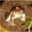

In [4]:
cifar10_train.data[0]

- 노드 수: 입력 노드의 1.5배~2배로 시작하여 실험을 통해 조정.
- 배치 크기: 32 또는 64로 시작하고, 메모리 상황에 맞춰 조정.
- 학습 횟수: 50~100 에포크 정도로 시작하되, 조기 종료 기법 활용 가능.

In [17]:
batch_size = 100
learning_rate = 0.1
training_epochs = 30
loss_function = nn.CrossEntropyLoss()
network = MLP()
optimizer = torch.optim.SGD(network.parameters(), lr = learning_rate)

data_loader = DataLoader(dataset=cifar10_train,
                         batch_size=batch_size,
                         shuffle=True,
                         drop_last=True)

In [18]:
# network = network.to("cuda:0")  # gpu메모리 사용
network = network.to("cpu")   # cpu메모리 사용

network.train()
for epoch in range(training_epochs):
    avg_cost = 0
    total_batch = len(data_loader)


    for img, label in data_loader:
        # img = img.to("cuda:0")
        # label = label.to("cuda:0")
        img = img.to("cpu")
        label = label.to("cpu")

        pred = network(img)

        loss = loss_function(pred, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        avg_cost += loss / total_batch
    print('Epoch: %d, lr = %f, Loss = %f' %(epoch+1, optimizer.param_groups[0]['lr'], avg_cost))
print('Learning finished')

Epoch: 1, lr = 0.100000, Loss = 1.983696
Epoch: 2, lr = 0.100000, Loss = 1.761544
Epoch: 3, lr = 0.100000, Loss = 1.664696
Epoch: 4, lr = 0.100000, Loss = 1.594830
Epoch: 5, lr = 0.100000, Loss = 1.540028
Epoch: 6, lr = 0.100000, Loss = 1.485020
Epoch: 7, lr = 0.100000, Loss = 1.442566
Epoch: 8, lr = 0.100000, Loss = 1.402546
Epoch: 9, lr = 0.100000, Loss = 1.364444
Epoch: 10, lr = 0.100000, Loss = 1.324172
Epoch: 11, lr = 0.100000, Loss = 1.288914
Epoch: 12, lr = 0.100000, Loss = 1.257763
Epoch: 13, lr = 0.100000, Loss = 1.226651
Epoch: 14, lr = 0.100000, Loss = 1.189905
Epoch: 15, lr = 0.100000, Loss = 1.154521
Epoch: 16, lr = 0.100000, Loss = 1.119534
Epoch: 17, lr = 0.100000, Loss = 1.081578
Epoch: 18, lr = 0.100000, Loss = 1.050329
Epoch: 19, lr = 0.100000, Loss = 1.005452
Epoch: 20, lr = 0.100000, Loss = 0.981793
Epoch: 21, lr = 0.100000, Loss = 0.938755
Epoch: 22, lr = 0.100000, Loss = 0.898669
Epoch: 23, lr = 0.100000, Loss = 0.858070
Epoch: 24, lr = 0.100000, Loss = 0.821769
E

In [19]:
network = network.to("cpu")
network.eval()
with torch.no_grad(): # test에서는 기울기 계산 제외

  img_test = torch.tensor(np.transpose(cifar10_test.data,(0,3,1,2))) / 255.
  label_test = torch.tensor(cifar10_test.targets)

  prediction = network(img_test) # 전체 test data를 한번에 계산

  correct_prediction = torch.argmax(prediction, 1) == label_test
  accuracy = correct_prediction.float().mean()
  print('Accuracy:', accuracy.item())

Accuracy: 0.5407000184059143


## 결과값
1.
- 함수 정의
  - self.fc1 = nn.Linear(3072, 1024, bias=True)
  - self.fc2 = nn.Linear(1024, 512, bias=True)
  - self.fc3 = nn.Linear(512, 256, bias=True)
  - self.fc4 = nn.Linear(256, 128, bias=True)
  - self.fc5 = nn.Linear(128, 10, bias=True)
  - self.relu = nn.ReLU()
- batch_size = 64
- learning_rate = 0.1
- training_epochs = 30
> Accuracy: 0.5103999972343445

2.
- 함수 정의
  - self.fc1 = nn.Linear(3072, 4096, bias=True)
  - self.fc2 = nn.Linear(4096, 1024, bias=True)
  - self.fc3 = nn.Linear(1024, 256, bias=True)
  - self.fc4 = nn.Linear(256, 10, bias=True)
  - self.relu = nn.ReLU()
- batch_size = 100
- learning_rate = 0.1
- training_epochs = 30
> Accuracy: 0.5407000184059143